In [36]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import vgg16
from torchvision.transforms import v2
from torch.utils.data import DataLoader

# seed
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [37]:
# model
model = vgg16(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [38]:
'''課題3.3 発展2
GuidedBackpropagationによるCNNの可視化
'''

img_idx = 4
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [39]:
class GuidedBackprop:
    def __init__(self, model):
        self.model = model.eval()
        self.handlers = []  # フック保持用

        # 全 ReLU にフックを登録
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                self.handlers.append(
                    module.register_full_backward_hook(self.relu_hook)
                )

    def relu_hook(self, module, grad_input, grad_output):
        new_grad_input = []
        for g in grad_input:
            if g is None:
                new_grad_input.append(None)
            else:
                # ① クローンしてからクリップ
                g2 = g.clone()
                g2.clamp_(min=0.0)    # in-place でも問題なし
                new_grad_input.append(g2)
        return tuple(new_grad_input)

    def generate(self, input_tensor, target_class):
        # パラメータの勾配は不要
        for param in self.model.parameters():
            param.requires_grad = False
        input_tensor.requires_grad_()

        # フォワード & backward
        output = self.model(input_tensor)
        score = output[0, target_class]
        self.model.zero_grad()
        score.backward()

        # 結果を取得
        grad = input_tensor.grad.squeeze().permute(1,2,0).cpu().numpy()
        saliency = np.max(np.abs(grad), axis=2)
        saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())
        return saliency

    def close(self):
        # フック解除
        for h in self.handlers:
            h.remove()

In [40]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

for m in model.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

gbp = GuidedBackprop(model)
saliency = gbp.generate(img_2, label)
gbp.close()

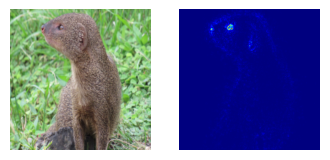

In [41]:
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(saliency, cmap='jet', vmin=0, vmax=1)